In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [74]:
df=pd.read_csv("cleaned_set.csv")
df=df.dropna()

In [75]:
x_train, x_test, y_train, y_test=train_test_split(df["tweet"],df["sentiment"],test_size=0.2,random_state=2)

In [76]:
#create count vector for each word in training set
cvector=CountVectorizer()
xcvector=cvector.fit_transform(x_train)
xcvector.shape

(6448, 9327)

In [77]:
#tf-idf transformation
tfidf_transformer=TfidfTransformer()
x_tfidf=tfidf_transformer.fit(xcvector)
x_tfidf=tfidf_transformer.transform(xcvector)

In [78]:
#check tf-idf score for a tweet  
df=pd.DataFrame(x_tfidf[0].T.todense(), index=cvector.get_feature_names(), columns=["tf-idf"])
df.sort_values(by=["tf-idf"],ascending=False)[:10]

,tf-idf
monterey,0.420840
18,0.402045
day,0.345066
town,0.327438
few,0.290889
until,0.284349
leave,0.283145
wait,0.262410
more,0.216283
can,0.171133


In [79]:
#cross validating on various classifiers
models=[LogisticRegression,LinearSVC,MultinomialNB]
temp=[]
k=6
cols=["fold","classifier","accuracy"]
for model in models:
    classifier=model()
    classifier_name=model.__name__
    accuracies=cross_val_score(classifier,x_tfidf,y_train,scoring="accuracy",cv=k)
    for fold in range(k):
        row=temp.append([fold,classifier_name,accuracies[fold]])
new_df=pd.DataFrame(temp,columns=cols)        

/home/noor/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


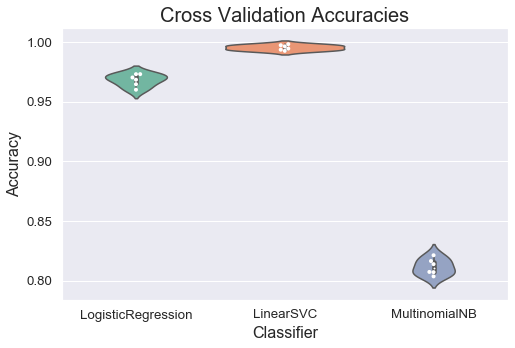

In [80]:
#visualize cross validation accuracies
plt.figure(figsize=(8,5))
sn.set(font_scale=1.2)
sn.set_style("darkgrid")
sn.violinplot(x="classifier",y="accuracy",data=new_df,palette="Set2")
sn.swarmplot(x="classifier",y="accuracy",data=new_df,color="white",size=4,edgecolor="gray")
plt.title('Cross Validation Accuracies',fontsize=20)
plt.xlabel("Classifier",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.show()

In [81]:
new_df.head()

,fold,classifier,accuracy
0,0,LogisticRegression,0.960000
1,1,LogisticRegression,0.970233
2,2,LogisticRegression,0.968372
3,3,LogisticRegression,0.973023
4,4,LogisticRegression,0.964618


In [82]:
#predicting on test set
xtest_cvector=cvector.transform(x_test)
xtest_tfidf=tfidf_transformer.transform(xtest_cvector)

model=LinearSVC()
model_name=model.__class__.__name__
model.fit(x_tfidf,y_train)
y_pred=model.predict(xtest_tfidf)

In [83]:
#evaluation
accuracy=accuracy_score(y_test,y_pred)
print("The Accuracy of %s model is %.4f." % (model_name,accuracy))

#classification report
report=classification_report(y_test,y_pred,target_names=["Depressed","Not Depressed"])
print(report)

The Accuracy of LinearSVC model is 0.9963.
               precision    recall  f1-score   support

    Depressed       1.00      0.99      0.99       412
Not Depressed       1.00      1.00      1.00      1200

     accuracy                           1.00      1612
    macro avg       1.00      0.99      1.00      1612
 weighted avg       1.00      1.00      1.00      1612



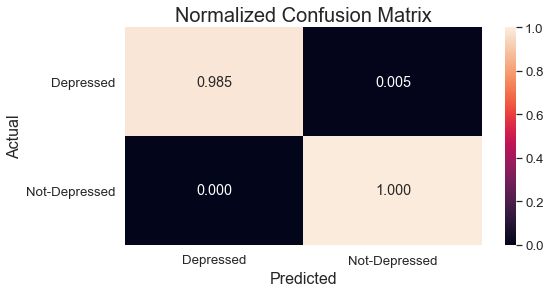

In [84]:
#confusion matrix
mat=confusion_matrix(y_test,y_pred)
mat_normal=mat/mat.astype(np.float).sum(axis=1)
plt.figure(figsize=(8,4))
sn.heatmap(mat_normal,annot=True,fmt='.3f',xticklabels=["Depressed","Not-Depressed"],yticklabels=["Depressed","Not-Depressed"])
plt.yticks(rotation=0)
plt.title("Normalized Confusion Matrix",fontsize=20)
plt.ylabel("Actual",fontsize=16)
plt.xlabel("Predicted",fontsize=16)
plt.show()